# Logit, Precision, Recall

This project uses baby-related item reviews from Amazon to build a bag-of-words model for sentiment analysis - check whether a review is positive or negative.

1. Read in data and initial formatting
2. Build sparse matrix (bag of words) from training data and test data
3. Train logistic regression model on training data matrix 
4. Evaluate model performance on test data

5. Change probability threshold to explore precision-recall curve: effects of favoring false positive or false negatives as preferred error type

In [1]:
import os, sys, csv, string

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from __future__ import division # 5/2 = 2.5

%matplotlib inline

# Initial data formatting

1. Read in data (amazon_baby.csv)

2. Remove punctuation

3. Remove 3-star reviews (assume neutral)

4. Denote 4,5-star reviews as +1, 1,2-star reviews as -1 (positive & negative classes)

### Read in data

In [2]:
#data readin

dtype_dict = {'name':str, 'review':str, 'rating':int}

df1 = pd.read_csv('amazon_baby.csv', dtype=dtype_dict)
df1 = df1.fillna({'review':''})  # fill in N/A's in the review column with empty strings
#df1.head()
print len(df1)    

183531


### Remove punctuation

In [3]:
def remove_punctuation(text):
    return text.translate(None, string.punctuation) 

In [4]:
#remove punctuation and check

df1['review_clean'] = df1['review'].apply(remove_punctuation)
df1.head()


,name,review,rating,review_clean
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,These flannel wipes are OK but in my opinion n...
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...


### Remove neutral reviews (3 stars)

In [5]:
#remove neutral reviews

df2 = df1[df1['rating'] !=3]
df2.head()

,name,review,rating,review_clean
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...


### Create binary sentiment feature based on rating

In [6]:
#define sentiment feature: +1 (pos) if 4,5 stars, -1 (neg) if 1,2 stars

g = lambda x: 1 if x > 3 else -1
df2['sentiment'] = df2['rating'].apply(g) #complains but works

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Logistic Model training

1. Divide data into training (80%) and test (20%) sets
2. Create bag-of-words representation (matrix) of training data, transform test data in the same way
3. Train logistic regression model on training data
4. Evaluate model performance using test data 

### Split data into test and train subsets (20% test, 80% train)

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df2, test_size = 0.2) #20% test, 80% train

### Create bag-of-words sparse matrices from test and train data

In [8]:
# Learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
# Convert the test data into a sparse matrix, using the same word-column mapping

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b') #token pattern to keep single-letter words
train_matrix = vectorizer.fit_transform(train['review_clean'])
test_matrix = vectorizer.transform(test['review_clean'])

### Train logistic regression model on training data

In [9]:
#Logistic regression model using the sparse word count matrix (train_matrix) as features and 
#the column sentiment of train_data as the target. 

from sklearn import linear_model

logit1 = linear_model.LogisticRegression()
model1 = logit1.fit(train_matrix, train['sentiment'])

### Evaluate model performance: 
1. Confusion matrix
2. Accuracy
3. Precision
4. Recall

In [10]:
# Print out the confusion matrix nicely formatted

from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_true=test['sentiment'].values,
                        y_pred=model1.predict(test_matrix),
                        labels=model1.classes_) 

print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
for i, target_label in enumerate(model1.classes_):
    for j, predicted_label in enumerate(model1.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3886
     -1       |        1        |  1426
      1       |       -1        |   878
      1       |        1        | 27161


In [13]:
#Model accuracy. 
#Compare function method to hand-calculated 
#Compare to baseline - always picking majority class

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true=test['sentiment'].values, y_pred=model1.predict(test_matrix))
print "Test Accuracy: %s" % accuracy

#check accuracy using confusion matrix entries (tp+tn/all)
print "Accuracy check: ",(cmat[1,1]+cmat[0,0])/(cmat[1,1]+cmat[0,0]+ cmat[0,1] + cmat[1,0])

#compare to baseline (pick majority class always)
baseline = len(test[test['sentiment'] == 1])/len(test)
print "Baseline accuracy: %s" % baseline

Test Accuracy: 0.930916614194
Accuracy check:  0.930916614194
Baseline accuracy: 0.840724416059


In [14]:
# Model precision - proportion of positive predictions that are truly positive

from sklearn.metrics import precision_score

precision = precision_score(y_true=test['sentiment'].values, 
                            y_pred=model1.predict(test_matrix))
print "Precision on test data: %s" % precision

#check precision: tp/(tp+fp)

print "Precision check: ",cmat[1,1]/(cmat[1,1]+cmat[0,1])

Precision on test data: 0.950117186134
Precision check:  0.950117186134


In [15]:
# Model recall - proportion of true positives that the model predicts to be positive

from sklearn.metrics import recall_score

recall = recall_score(y_true=test['sentiment'].values, 
                      y_pred=model1.predict(test_matrix))
print "Recall on test data: %s" % recall

#recall: tp/(tp+fn)

print "Recall check: ", cmat[1,1]/(cmat[1,1]+cmat[1,0])

Recall on test data: 0.968686472413
Recall check:  0.968686472413


### All the classification metrics in one place

In [17]:
# All the classification metrics in one place

from sklearn.metrics import classification_report

print "Classification report:"
print classification_report(y_true=test['sentiment'].values, 
                      y_pred=model1.predict(test_matrix))

Classification report:
             precision    recall  f1-score   support

         -1       0.82      0.73      0.77      5312
          1       0.95      0.97      0.96     28039

avg / total       0.93      0.93      0.93     33351



# Precision-recall curve

1. Test for single probability: 
   * change model threshold probability from 0.5 to 0.9 
   * retrain logit model 
   * reevaluate model performance
2. Produce precision-recall curve 

### Function to assign classes based on a chosen threshold value

In [18]:
#given iterable of probabilities and a threshold, return a numpy array
# of 1's for prob>threshold, -1's for prob<threshold
# i.e. make class predictions for probabilities given arbitrary threshold

def apply_threshold(probabilities, threshold):
    myarr = np.ones((len(probabilities),), dtype=np.int) #default 1
    for i, prob in enumerate(probabilities):
        if (prob < threshold): # -1 if <threshold
            myarr[i] = -1
    return myarr

### Compare to earlier results

In [19]:
#Check that this reproduces earlier result 

#Extract probabilities for model1 on test data matrix. (2nd column for +1 class)
probabilities = model1.predict_proba(test_matrix)[:,1]

#apply class predictions by hand using our own function
preds = apply_threshold(probabilities, 0.5)

counter = 0
for pred in preds:
    if pred == 1:
        counter += 1
print "Positive predictions (hand-apply threshold)",counter #should be equal 
print "Positive predictions (default)", cmat[0,1] + cmat[1,1] 

Positive predictions (hand-apply threshold) 28587
Positive predictions (default) 28587


### Apply a large threshold and look at performance metrics

In [20]:
#apply large threshold - 0.9 probability needed for assignment to positive class
#expect: few false positives = high precision; many false negatives = low recall

preds = apply_threshold(probabilities, 0.9)

recall = recall_score(y_true=test['sentiment'].values, 
                      y_pred=preds)
print "Recall on test data: %s" % recall
precision = precision_score(y_true=test['sentiment'].values, 
                            y_pred=preds)
print "Precision on test data: %s" % precision

#precision goes up, recall goes down with higher threshold:
# makes sense: more predictions are true, but miss some positives

Recall on test data: 0.874424908164
Precision on test data: 0.98087694031


### Scan through threshold values to get (precision, recall) pairs


In [21]:
threshold_values = np.linspace(0.5, 1, num=100)

precision_all = []
recall_all = []

for thr in threshold_values:
    preds = apply_threshold(probabilities, thr)

    recall = recall_score(y_true=test['sentiment'].values, 
                          y_pred=preds)
    precision = precision_score(y_true=test['sentiment'].values, 
                                y_pred=preds)
        
    recall_all.append(recall)
    precision_all.append(precision)


### Plot to get precision-recall curve

In [22]:
#plot defaults

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

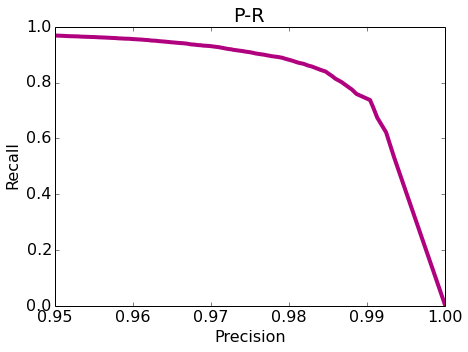

In [23]:
plot_pr_curve(precision_all,recall_all, "P-R")